# Optical Astronomical Instrumentation: Introduction
Author: Johan Mazoyer, September 2021

This notebook shows the basics of Optical Astronomical Instrumentation with the creation of Point Spread Functions (PSF) for circular and Hubble telescope like pupils. In the second part, we introduce realistic noise to this image to understand the basics of Signal to Noise Ratio in Astronomy.

It was created for the Introduction Course of the Master course Instrumentation in the M2 IRT  from Paris Observatory (PSL). 



In [91]:
import os
import numpy as np
from scipy import constants
import scipy.ndimage as nd
from matplotlib import pyplot as plt, cm
from matplotlib.colors import LogNorm

from astropy.io import fits

import scipy.fftpack as sfft

img_size = 10


def create_circular_pup(dim_im, prad):
    """ 
    This function creates a binary circular pupil of radius prad in a 
    2D numpy array of shape (dim_im,dim_im), with 1 inside the pupil 
    and 0 outside.
    
    Author : Johan Mazoyer

    Parameters
    ----------
    dim_im: int  
            Size of the returned array in pixel
    prad: float
            Radius of the pupil in pixel
     
    Returns
    ------
    round_pup: 2d numpy array
            circular pupil of radius prad in a 2D numpy array of shape (dim_im,dim_im)
    """
    # Create 2 ramps in 2D numpy array xx and yy centered at the middle of the array
    xx, yy = np.meshgrid(np.arange(dim_im) - (dim_im) / 2, np.arange(dim_im) - (dim_im) / 2)
    
    # Using these, create a rr coordinate array. Each pixels value is the distance to the center of
    # the image. We add 1/2 to be centered "in between 4 pixels"
    rr = np.hypot(yy + 1 / 2, xx + 1 / 2)
    
    
    round_pup = np.zeros((dim_im, dim_im))
    round_pup[rr <= prad] = 1.0
    
    return round_pup



def create_hubble_pup(dim_im, prad):
    
    """ 
    This function creates a binary hubble pupil of radius prad in a 
    2D numpy array of shape (dim_im,dim_im), with 1 inside the pupil 
    and 0 outside.
    
    Author : Johan Mazoyer

    Parameters
    ----------
    dim_im: int  
            Size of the returned array in pixel
    prad: float
            Radius of the pupil in pixel
     
    Returns
    ------
    hubble_pup: 2d numpy array
            Hubble pupil of radius prad in a 2D numpy array of shape (dim_im,dim_im)
    """
    
    # Parameter of the Hubble pupil. These values are used to create
    # the features with size relatively correct but do not change the size of the pupil,
    # set using prad
    diam_hubble = 2.4 #m
    diam_inner_hublbe = 0.79  #m
    width_struts_hubble =  0.0264  #m

    diam_small_circular_obscurations = 2*0.078  #m

    pos_small_circular_obscuration1 = [0. ,- 1.0705]  
    pos_small_circular_obscuration2 = [-0.9066,+0.5538]  
    pos_small_circular_obscuration3 = [+ 0.9127,+0.5477] 

    # Create 2 ramps in 2D numpy array xx and yy centered at the middle of the array
    # We add 1/2 to be centered "in between 4 pixels"
    xx, yy = np.meshgrid(np.arange(dim_im) - (dim_im) / 2 + 1 / 2, np.arange(dim_im) - (dim_im) / 2 + 1 / 2)
    rr = np.hypot(yy , xx )
    
    # Create the outer radius pupil
    hubble_pup = np.zeros((dim_im, dim_im))
    hubble_pup[rr <= prad] = 1.0
    
    # Create the inner radius central obscuration
    hubble_pup[rr <= prad/diam_hubble*diam_inner_hublbe] = 0.
    
    # Create the struts
    hubble_pup[np.where(np.abs(xx)< prad/diam_hubble*width_struts_hubble) ] = 0.
    hubble_pup[np.where(np.abs(yy)< prad/diam_hubble*width_struts_hubble) ] = 0.

    # Add the 3 smaller obscurations of radius diam_small_circular_obscurations
    rr1 = np.hypot(
        yy + pos_small_circular_obscuration1[1] * prad / diam_hubble * 2,
        xx + pos_small_circular_obscuration1[0] * prad / diam_hubble * 2)
    hubble_pup[rr1 <= prad / diam_hubble *
               diam_small_circular_obscurations] = 0.

    rr2 = np.hypot(
        yy + pos_small_circular_obscuration2[1] * prad / diam_hubble * 2,
        xx + pos_small_circular_obscuration2[0] * prad / diam_hubble * 2)
    hubble_pup[rr2 <= prad / diam_hubble *
               diam_small_circular_obscurations] = 0.

    rr3 = np.hypot(
        yy + pos_small_circular_obscuration3[1] * prad / diam_hubble * 2,
        xx + pos_small_circular_obscuration3[0] * prad / diam_hubble * 2)
    hubble_pup[rr3 <= prad / diam_hubble *
               diam_small_circular_obscurations] = 0.

    return hubble_pup

def show_pup(pup, dim_im, prad):
    fig = plt.figure(figsize=(img_size,img_size))
    ax = fig.add_subplot(111)
    plt.axis('off')
    ax.set_aspect('equal', adjustable='box')
    plt.axis('off')
    plt.imshow(
        pup[dim_im // 2 - int(1.1 * prad):dim_im // 2 + int(1.1 * prad),
            dim_im // 2 - int(1.1 * prad):dim_im // 2 + int(1.1 * prad)],
        origin='lower',
        cmap='gray')
    plt.show()
    plt.close()


def show_psf(PSF, dim_im, prad, norm = True, vmin = -0.0005, vmax = 0.0005):
    fig = plt.figure(figsize=(img_size,img_size))
    ax = fig.add_subplot(111)
    plt.axis('off')
    ax.set_aspect('equal', adjustable='box')
    number_res = 18
    if norm:
        PSFplot = PSF / np.max(PSF)
    else:
        PSFplot = PSF
    plt.pcolor(PSFplot[dim_im // 2 - number_res * dim_im //
                        (2 * prad):dim_im // 2 + number_res * dim_im //
                        (2 * prad), dim_im // 2 - number_res * dim_im //
                        (2 * prad):dim_im // 2 + number_res * dim_im // (2 * prad)] ,
            cmap = 'viridis',
           vmin=vmin, vmax=vmax)
    plt.show()
    plt.close()



In [92]:

# This link can be used to save .fits file of the images created in this class
dir_psf = 'imgs/'


##  Pupils  and PSFs

These 2 parameters are used to set the size of the array and of the radius of the pupil inside. These 2 parameters will set the frequency content of the Fourier Tranform of the Pupil (i.e. the PSF). The number of pixel in the resolution element of the PSF (Lambda / D) will be set by this value (dim_im / 2*prad).

Finally, because of ths Nyquist-Shannon theorem, the Fourier Tranform of the pupil FFT will suffer from
numerical artefacts (folding), if the diameter of the pupil (2*prad) is larger than half the dimension of the pupil. Therefore, to avoid these effects one need to ensure 2*prad < dim_im/2

In [93]:
dim_im = 1000
prad = 100

### Circular pupil and PSF (Airy disk)

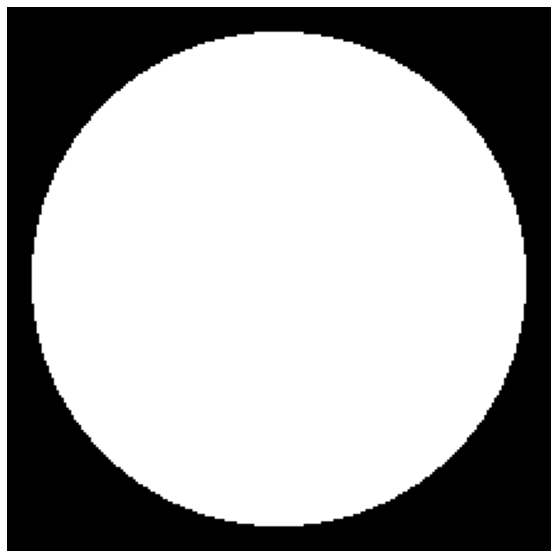

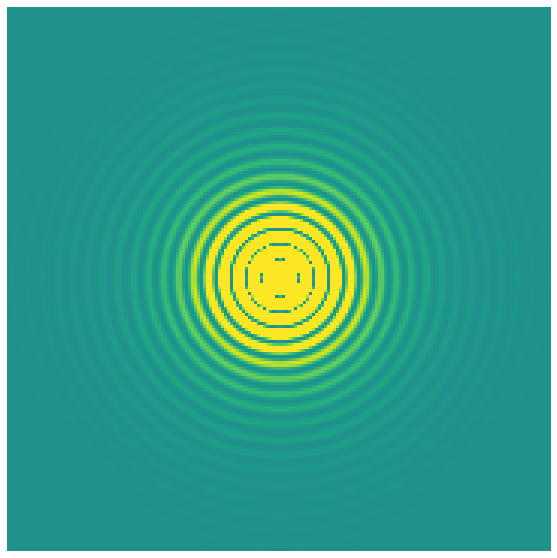

In [94]:
circular_pup = create_circular_pup(dim_im, prad )
show_pup(circular_pup,dim_im, prad)


circular_PSF = np.abs(np.fft.fftshift(np.fft.fft2(circular_pup)))**2
# use np.fft.fftshift and np.fft.fft2 functions


show_psf(circular_PSF, dim_im, prad)

# fits.writeto(dir_psf+ "circular_aperture.fits", circular_pup, overwrite=True)
# fits.writeto(dir_psf+ "circular_aperture_PSF.fits", circular_PSF, overwrite=True)

### Hubble pupil and PSF

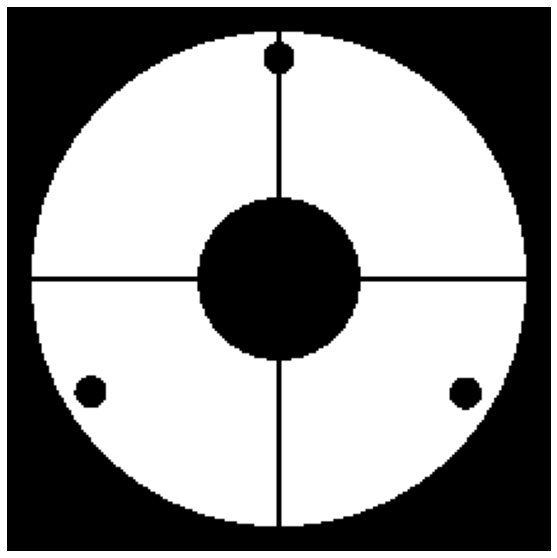

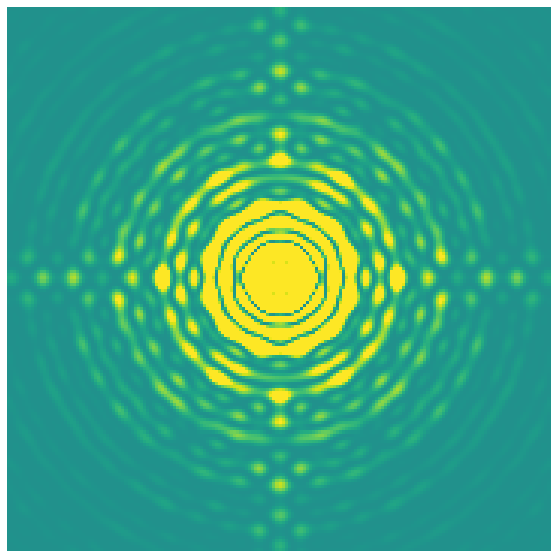

In [95]:
hubble_pup = create_hubble_pup(dim_im, prad )
show_pup(hubble_pup,dim_im, prad)

hubble_PSF = np.abs(np.fft.fftshift(np.fft.fft2(hubble_pup)))**2
show_psf(hubble_PSF, dim_im, prad)

fits.writeto(dir_psf+ "hubble_pup.fits", hubble_pup, overwrite=True)
##fits.writeto(dir_psf+ "hubble_aperture_PSF.fits", hubble_PSF, overwrite=True)

In [96]:
Z_fft = sfft.fft2(hubble_pup)


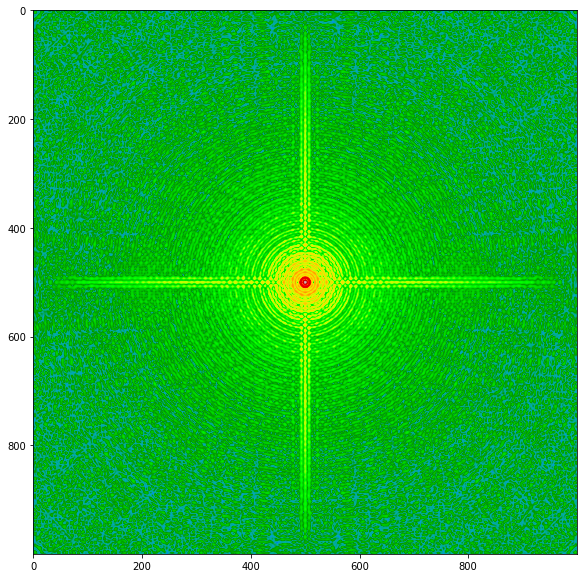

In [97]:
Z_shift = sfft.fftshift(Z_fft)
plt.figure(figsize=(img_size,img_size))
plt.imshow(np.log10(abs(Z_shift)),cmap="nipy_spectral")